In [1]:
#Script run on www.Kaggle.com
import os
import numpy as np
import matplotlib.pyplot as plt
import h5py
h5py._errors.unsilence_errors()
from mpl_toolkits.axes_grid1 import make_axes_locatable

# SUGGESTION: create all folders for storing results
if not os.path.exists('./vis'):
    os.mkdir('./vis')

if not os.path.exists('./vis_results'):
    os.mkdir('./vis_results')

if not os.path.exists('./model256_weights'):
    os.mkdir('./model256_weights')

# if not os.path.exists('./tb_logs'):
#     os.mkdir('./tb_logs')

if not os.path.exists('./lightning_logs'):
    os.mkdir('./lightning_logs')

In [2]:
#import other module

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

#you need to put dataset.py and pre_processing.py files as a "dataset" in the folder named helpfunction9
import sys
sys.path.append('/kaggle/input/helpfunction9/')




/kaggle/input/track2dataset/256modelruns/Pe1_K1_0_0.hdf5
/kaggle/input/track2dataset/256modelruns/Pe1_K1_1_1.hdf5
/kaggle/input/track2dataset/256modelruns/Pe1_K1_3_3.hdf5
/kaggle/input/track2dataset/256modelruns/Pe1_K1_2_2.hdf5
/kaggle/input/track2dataset/256modelruns/Pe1_K1_3_0.hdf5
/kaggle/input/track2dataset/256modelruns/Pe1_K1_0_3.hdf5
/kaggle/input/track2dataset/256modelruns/Pe1_K1_1_2.hdf5
/kaggle/input/track2dataset/256modelruns/Pe1_K1_3_1.hdf5
/kaggle/input/track2dataset/256modelruns/Pe1_K1_1_3.hdf5
/kaggle/input/track2dataset/256modelruns/Pe1_K1_0_1.hdf5
/kaggle/input/track2dataset/256modelruns/Pe1_K1_2_0.hdf5
/kaggle/input/track2dataset/256modelruns/Pe1_K1_0_2.hdf5
/kaggle/input/track2dataset/256modelruns/Pe1_K1_2_1.hdf5
/kaggle/input/track2dataset/256modelruns/Pe1_K1_1_0.hdf5
/kaggle/input/track2dataset/256modelruns/Pe1_K1_3_2.hdf5
/kaggle/input/track2dataset/256modelruns/Pe1_K1_2_3.hdf5
/kaggle/input/helpfunction9/dataset.py
/kaggle/input/helpfunction9/pre_processing.py


In [3]:
!pip install -U segmentation_models_pytorch
!pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
!pip install lightning
!pip install tensorboard
!pip install torchviz

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 3.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.5/68.5 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 45.4 MB/s eta 0:00:0000:01
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16428 sha256=a1f40605bb4b9c74fe67be0c30eeb41ffbd3f3afeebe96dea87227e6de31a6ba
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60945 sha256=eb3bff21f6d5d7b455015d7a825120dd3dcc7b8b80737ac4420326403cc64d94
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built efficientnet-py

    Import Lightning: Import the necessary modules from PyTorch Lightning

In [4]:
import torch
from torch import nn
from torch.utils.data import DataLoader, random_split

import lightning as L

import albumentations as albu

import segmentation_models_pytorch as smp
import numpy as np
from datetime import datetime
from tqdm.notebook import tqdm

import torch.nn.functional as F
import pandas as pd

from itertools import product
import h5py


from torch.utils.data import RandomSampler

    Define LightningModule: Create a LightningModule class that inherits from pl.LightningModule. This class will contain your model architecture and training logic.



In [5]:
class MyLightningModel(L.LightningModule):
    def __init__(self):
        super().__init__()
        
        self.model = smp.Unet(
            encoder_name='resnet34',
            encoder_weights=None,
            in_channels=4,
            classes=4,
            activation='sigmoid'
        )
        self.l2_loss = torch.nn.MSELoss()
        self.l1_loss = torch.nn.L1Loss()
        
        #save all hyperparameters
        self.save_hyperparameters()
        
        self.record_trainloss=[]
        self.record_valoss=[]
        self.record_testloss=[]
        
        self.validation_step_outputs = []
        self.training_step_outputs = []
    
    
#         #record test
#         self.all_test_input=[]
#         self.all_test_preds = []
#         self.all_test_masks = []
            
        
    #When using forward, you are responsible to call eval() and use the no_grad() context manager.
    def forward(self, x):
        
        return self.model(x)

    def training_step(self, batch, batch_idx):
        imgs, masks = batch
        preds = self.model(imgs).squeeze()
        
        loss = self.l1_loss(preds, masks)
        
        self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        #self.logger.experiment.add_scalar('train_loss',loss, self.current_epoch)
        
        self.training_step_outputs.append(loss)

        return loss
    
    def validation_step(self, batch, batch_idx):
        imgs, masks = batch
        preds = self.model(imgs).squeeze()
        
        #print(f"imgs {imgs.shape},masks{masks.shape},preds{preds.shape}")
        
        val_loss = self.l1_loss(preds, masks)
        
        self.log('val_loss', val_loss, prog_bar=True)
        #self.logger.experiment.add_scalar('val_loss',val_loss, self.current_epoch)
        
        self.validation_step_outputs.append(val_loss)
        
        return val_loss
    
    def test_step(self, batch, batch_idx):
        
        imgs, masks = batch
        preds = self.model(imgs).squeeze()
        
#         self.all_test_input.append( imgs[:,1,:,:].squeeze() )
#         self.all_test_masks.append( masks[:,1,:,:].squeeze() )
#         self.all_test_preds.append( preds[:,1,:,:].squeeze() )
        
        
        
        test_loss = self.l1_loss(preds, masks)
        
        self.log("test_loss", test_loss, prog_bar=True)
        
#         metrics = {"test_loss": test_loss}
#         self.log_dict(metrics)
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam([ dict(params=self.model.parameters(), lr=5e-4),])
        
        return optimizer

    def on_train_epoch_end(self):
        avg_train_loss = torch.stack(self.training_step_outputs).mean()
        
        self.record_trainloss.append(avg_train_loss)
        
        self.training_step_outputs=[]
        #self.log('all_train_losses', all_train_loss)
        
        
    
    def on_validation_epoch_end(self):
        avg_val_loss = torch.stack(self.validation_step_outputs).mean()
        
        
        self.record_valoss.append(avg_val_loss)
        
        self.validation_step_outputs=[]




    Define LightningDataModule: If you're using custom data loaders, create a LightningDataModule class that inherits from pl.LightningDataModule. This class will contain your data loading logic.

In [6]:

from dataset import MyDataset

    
class MyDataModule(L.LightningDataModule):
    def __init__(self, augmentation=None, preprocessing=None, batch_size=64):
        super().__init__()
        self.batch_size = batch_size
        self.augmentation = augmentation
        self.preprocessing = preprocessing
        self.n_training_samples = 10
        self.n_valid_samples = 2
        self.n_test_samples = 4

        
    def setup(self, stage=None):

        #get the file names
        permutations = list(product(range(4), repeat=2))
        file_list = []
        properties_list = []
        for idx1, idx2 in permutations:
            file_name = f'/kaggle/input/track2dataset/256modelruns/Pe1_K1_{idx1}_{idx2}.hdf5'
            file_list.append(file_name)


        # # set breakpoint
        # import pdb
        #pdb.set_trace()
        #self.example_dataset = MyDataset(file_list[:3],self.augmentation[0], self.preprocessing)
        self.train_dataset = MyDataset(file_list[:self.n_training_samples],self.augmentation[0], self.preprocessing)
        self.val_dataset = MyDataset(file_list[self.n_training_samples : self.n_training_samples+self.n_valid_samples], None, self.preprocessing)
        
        self.test_dataset = MyDataset(file_list[-self.n_test_samples :], None, self.preprocessing)
     
    def train_dataloader(self):
        train_sampler = RandomSampler(self.train_dataset, replacement=True, num_samples=10000) 
        return DataLoader(self.train_dataset, batch_size=self.batch_size, sampler=train_sampler, num_workers=2, drop_last=False, persistent_workers=True) # 

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size, num_workers=2, shuffle=False, drop_last=False, persistent_workers=True)
    
    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size, num_workers=2, shuffle=False, persistent_workers=True)
    
    
    def get_train_data(self):
        return DataLoader(self.train_dataset, batch_size=1, shuffle=False, num_workers=1)
    
    def get_test_data(self):
        return DataLoader(self.test_dataset, batch_size=1, shuffle=False, num_workers=1)
    

   

    Training Loop with Trainer: Create a pl.Trainer object and use it to train your LightningModule.

* from commandline, type tensorboard --logdir=lightning_logs/



In [7]:
def get_training_augmentation():
    train_transform = [
        albu.Resize(256, 256),  # not needed
#         albu.HorizontalFlip(p=0.5),
#         albu.VerticalFlip(p=0.5),
    ]
    return albu.Compose(train_transform)

def get_validation_augmentation():
    """Resize to make image shape divisible by 32"""
    test_transform = [
        albu.Resize(256, 256),  
    ]
    return albu.Compose(test_transform)

In [8]:
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from lightning.pytorch.callbacks import ModelSummary
from lightning.pytorch.callbacks import TQDMProgressBar
from lightning.pytorch.callbacks import DeviceStatsMonitor
from lightning.pytorch.profilers import AdvancedProfiler

from pre_processing import get_preprocessing

from lightning.pytorch.loggers import TensorBoardLogger


augumentations=[get_training_augmentation(), get_validation_augmentation(), get_validation_augmentation()]
# if __name__ == "__main__":

model = MyLightningModel()

data_module = MyDataModule(augmentation=augumentations, preprocessing=get_preprocessing())


# profiler = AdvancedProfiler(dirpath=".", filename="lightning_logs/perf_logs")
#profiler=profiler, default_root_dir='/Users/captainjack/Desktop/CO2_Storage_Jack/'
#consider trying mix precision https://lightning.ai/docs/pytorch/stable/common/precision_intermediate.html
#fast_dev_run=True,
#ModelSummary(max_depth=-1), no need for baseline model
#profiler="simple"

# logger = TensorBoardLogger("tb_logs", name="my_model")

from lightning.pytorch.callbacks import ModelCheckpoint

#save per epoch!
checkpoint_callback = ModelCheckpoint(
    dirpath='/kaggle/working/',
    filename='model-{epoch:04d}',
    save_top_k=1,  # Save all checkpoints
    monitor=None,  # Disable monitoring
    verbose=True
)


trainer = L.Trainer(max_epochs=7,default_root_dir='/kaggle/working/',\
                     callbacks=[checkpoint_callback,TQDMProgressBar(refresh_rate=32),\
                                EarlyStopping(monitor="val_loss", min_delta=0.001, patience=3, \
                                              verbose=False)])
#VisualizationCallback(data_module)

# check validation before large training step
#num_sanity_val_steps=2, 

#stop
trainer.fit(model, data_module)

train_loss=model.record_trainloss
val_loss=model.record_valoss


trainer.save_checkpoint("/kaggle/working/example.ckpt")


# test the model  [for data to plot!]
trainer.test(model, data_module) 


INFO: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
2024-03-15 19:33:04.039055: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-15 19:33:04.039167: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-15 19:33:04.172379: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/opt/conda/lib/python3.10/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:653: Checkpoint directory /kaggle/working exists and is not empty.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=7` reached.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │   0.004098101984709501    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.004098101984709501}]

In [9]:
# from torchviz import make_dot

# x = torch.zeros(64, 4, 256, 256, dtype=torch.float, requires_grad=False)
# out = model(x)

# make_dot(out) 

# make_dot(out, params=dict(list(model.named_parameters()))).render("plotmodel", format="png")

In [10]:
train_loss=model.record_trainloss
val_loss=model.record_valoss

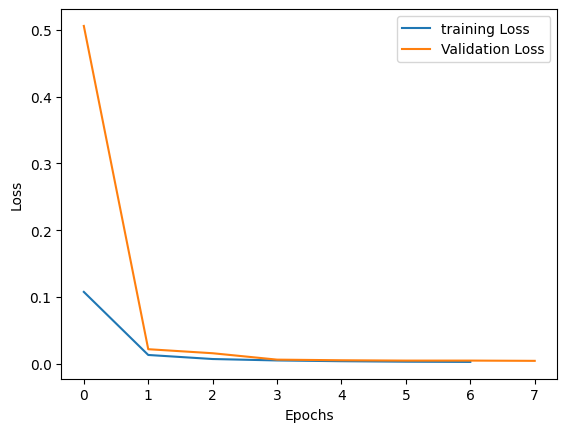

In [11]:
train_losscpu=[t.cpu().detach().numpy() for t in train_loss]
val_losscpu=[t.cpu().detach().numpy() for t in val_loss]

plt.figure()
plt.plot(train_losscpu, label="training Loss")
plt.plot(val_losscpu, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()



View logs in tensorboard

If you’re using a notebook environment such as colab or kaggle or jupyter, launch Tensorboard with this command

%reload_ext tensorboard
%tensorboard --logdir=lightning_logs/

In [12]:
# !kill 400      
# %reload_ext tensorboard
# %tensorboard --logdir lightning_logs/


Some Plots

In [13]:
# #the following code is not correct for dataloading, deleted
# def visualize(**images):
#     """Plot images in one row."""
#     n = len(images)
#     plt.figure(figsize=(16, 5))
#     for i, (name, image) in enumerate(images.items()):
#         plt.subplot(1, n, i + 1)
#         plt.xticks([])
#         plt.yticks([])
#         plt.title(' '.join(name.split('_')).title())
#         plt.imshow(image)
#     plt.show()

# for idx_ in range(4):
#     current_timestep = 20*idx_
#     print(f'plotting for time step: {current_timestep}')
#     image, mask = data_module.val_dataset[current_timestep] # get some sample
#     visualize(
#         concentration=image[0,:, :].squeeze(),
#         eps=image[1,:, :].squeeze(),
#         Ux=image[2,:, :].squeeze(),
#         Uy=image[3,:, :].squeeze(),
#         dissolution=mask[1,:, :].squeeze(),
#     )

use class dataloader to plot

In [14]:
#concatenate data

# input_list_val = torch.cat(model.all_test_input, dim=0)
# masks_list_val= torch.cat(model.all_test_masks, dim=0)
# preds_list_val  = torch.cat(model.all_test_preds, dim=0)



In [15]:
def matshow_error(input1, pred, truth, figsize=(40, 18), scale=False, title=None, filename=None):
    fig, ax = plt.subplots(1, 4, figsize=figsize)
    
    v_max = max(input1.max(), pred.max())
    v_min = max(input1.min(), pred.min())

    if scale:
        im = ax[0].matshow(input1, vmin=0, vmax=1, cmap=plt.get_cmap('Reds'))# 'inferno_r'))
    else:
        im = ax[0].matshow(input1, vmin=v_min, vmax=v_max, cmap=plt.get_cmap('Reds'))# 'inferno_r'))
    
    # im.set_clim(0.0, 0.3)
    ax[0].set_title(f'{title} input')
    divider = make_axes_locatable(ax[0])
    cax = divider.append_axes("right", size="2%", pad=0.1)
    cbar = plt.colorbar(im, cax=cax)

    if scale:
        im = ax[1].matshow(truth, vmin=0, vmax=1, cmap=plt.get_cmap('Reds'))# 'inferno_r'))
    else:
        im = ax[1].matshow(truth, vmin=v_min, vmax=v_max, cmap=plt.get_cmap('Reds'))# 'inferno_r'))   
    
    
    # im.set_clim(0.0, 0.3)
    ax[0].set_title(f'{title} prediction')
    divider = make_axes_locatable(ax[1])
    cax = divider.append_axes("right", size="2%", pad=0.2)
    cbar = plt.colorbar(im, cax=cax)

    if scale:
        im = ax[2].matshow(truth, vmin=0, vmax=1, cmap=plt.get_cmap('Reds'))# 'inferno_r'))
    else:
        im = ax[2].matshow(truth, vmin=v_min, vmax=v_max, cmap=plt.get_cmap('Reds'))# 'inferno_r'))
    
    # im.set_clim(0.0, 0.3)
    ax[1].set_title(f'{title} reference')
    divider = make_axes_locatable(ax[2])
    cax = divider.append_axes("right", size="2%", pad=0.3)
    plt.colorbar(im, cax=cax)

    # error = np.abs(pred-truth)
    error = pred-truth

    im = ax[3].matshow(error, cmap=plt.get_cmap('seismic')) #.get_cmap('RdGy'))
    max_abs_error = np.max(np.abs(error))
    # Set the color limits dynamically centered around zero
    clim = (-max_abs_error, max_abs_error)
    im.set_clim(clim)

    ax[3].set_title(f'{title} error')
    divider = make_axes_locatable(ax[3])
    cax = divider.append_axes("right", size="2%", pad=0.4)
    plt.colorbar(im, cax=cax)
    plt.tight_layout()
    if filename is not None:
        plt.savefig(filename)
    plt.show()

    
    
    
# for sample_idx in range(1): #12):
#     for time_step in [0, 1, 3, 7, 10, 20, 40, 60, 90, 99]:
#         preds = preds_list_train[sample_idx*100+time_step, :, :]
#         masks = masks_list_train[sample_idx*100+time_step, :, :]
#         # matshow2(scaling_func(preds), scaling_func(masks), title=f'train sample: {sample_idx}, scaled prediction eps', filename='original_eps.pdf')
#         matshow_error(
#             preds,
#             masks, 
#             title=f'train sample: {sample_idx}, timestep: {time_step}, eps: ', 
#             filename=f'vis_results/training_eps_{sample_idx}_{time_step}.pdf',
#             figsize=(15, 7))
        
for sample_idx in range(0): #4):
    for time_step in [0, 1, 3, 7, 10, 20, 40, 60, 90, 99]:
        inputs= input_list_val[sample_idx*100+time_step, :, :].cpu().numpy()
        preds = preds_list_val[sample_idx*100+time_step, :, :].cpu().numpy()
        masks = masks_list_val[sample_idx*100+time_step, :, :].cpu().numpy()
        # matshow2(scaling_func(preds), scaling_func(masks), title=f'validation sample: {sample_idx}, scaled prediction eps', filename='original_eps.pdf')
        matshow_error(inputs,
            preds,
            masks,
            title=f'validation sample: {sample_idx}, timestep: {time_step}, eps: ', 
            filename=f'vis_results/validation_eps_{sample_idx}_{time_step}.pdf',
            figsize=(15, 7))

In [ ]:
model = MyLightningModel.load_from_checkpoint('/kaggle/working/example.ckpt')
model.eval()

train_dataloader = data_module.get_train_data()

train_inputlist=[]
# train_outputlist=[]
train_truelist=[]

for batch in train_dataloader:
    img,mask=batch
    #pred=model(img)
    train_inputlist.append(img)
    train_truelist.append(mask)
    
train_inputlists = torch.cat(train_inputlist, dim=0)
train_inputlists = torch.cat(train_truelist, dim=0)

train_outputlist=model(train_inputlists).squeeze()








In [ ]:
#auto-regression, see here:https://lightning.ai/docs/pytorch/stable/notebooks/course_UvA-DL/10-autoregressive-image-modeling.html